In [11]:
import pandas as pd
import tweepy
import csv
import json


ACCESS_TOKEN = ''
ACCESS_SECRET = ''
CONSUMER_KEY = ''
CONSUMER_SECRET =''

auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)
api = tweepy.API(auth,wait_on_rate_limit=True)


c = tweepy.Cursor(api.search, q='coronavirus', lang='en')

count=201
page_needed=int(count/15) + 3
c.pages(page_needed)

id_tweets = []
date = []
full_text_tweet =[]
for tweet in c.items():
    try:
        tweet = api.get_status(tweet.id, count=200, tweet_mode="extended")
        full_text_tweet.append(tweet.full_text)
        id_tweets.append(tweet.id)
    except:
        pass
    if len(full_text_tweet)==count: 
        break       
print("Total Data length", len(full_text_tweet))

Total Data length 201


In [12]:
from sklearn.externals import joblib 
import string
import re
import pickle
import pandas as pd
from sklearn.base import TransformerMixin, BaseEstimator
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize


In [13]:
tweets = pd.Series(full_text_tweet)

In [14]:

HAPPY_EMO = r" ([xX;:]-?[dD)]|:-?[\)]|[;:][pP]) "
SAD_EMO = r" (:'?[/|\(]) "




def lemmatize_tokenize(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in word_tokenize(text)]


    

class TextPreProc(BaseEstimator,TransformerMixin):
    def __init__(self, use_mention=False):
        self.use_mention = use_mention
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        # We can choose between keeping the mentions
        # or deleting them
        if self.use_mention:
            X = X.str.replace(r"@[a-zA-Z0-9_]* ", " @tags ")
        else:
            X = X.str.replace(r"@[a-zA-Z0-9_]* ", "")
            
        # Keeping only the word after the #
        X = X.str.replace("#", "")
        X = X.str.replace(r"[-\.\n]", "")
        # Removing HTML garbage
        X = X.str.replace(r"&\w+;", "")
        # Removing links
        X = X.str.replace(r"https?://\S*", "")
        # replace repeated letters with only two occurences
        # heeeelllloooo => heelloo
        X = X.str.replace(r"(.)\1+", r"\1\1")
        # mark emoticons as happy or sad
        X = X.str.replace(HAPPY_EMO, " happyemoticons ")
        X = X.str.replace(SAD_EMO, " sademoticons ")
        X = X.str.lower()
        return X


In [15]:
#Random Forest Model
RF_model = joblib.load('RF_MODEL.pkl')
#Feature Vector
with open('RF_SVC_tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)


C:\Users\Mert\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\Mert\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.20.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\Mert\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.20.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\Mert\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.20.1 when u

In [16]:
tweets = tokenizer.transform(tweets)

C:\Users\Mert\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\feature_extraction\text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'doe', 'ha', 'might', 'must', "n't", 'need', 'sha', 'wa', 'wo', 'would'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [17]:
pos_count=0
neg_count=0
neutral_count=0

In [18]:
sentiments=[]
for i in range(len(full_text_tweet)):
    result=RF_model.predict_proba(tweets[i])[0]
    if result[0] > 0.60:
        sentiments.append("😃")
        pos_count = pos_count+1

        #print("Text : " + full_text_tweet[i] + " Sentiment : 😃")
    elif result[0] < 0.40:
        sentiments.append("😔")
        neg_count = neg_count+1
        #print("Text : " + full_text_tweet[i] + " Sentiment : 😔")
    else:
        sentiments.append("😐")
        neutral_count=neutral_count+1

        #print("Text : " + full_text_tweet[i] + " Sentiment : 😐")
sentiments = pd.Series(sentiments, name="Sentiment")
full_text_tweet = pd.Series(full_text_tweet, name="Tweet")        
result_dataframe = pd.concat([full_text_tweet, sentiments], axis=1)
    
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', -1)
        

C:\Users\Mert\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:24: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [19]:
result_dataframe


,Tweet,Sentiment
0,"RT @Rosie: Rep. Ilhan Omar said her father had died from complications of the coronavirus. ""No words can describe what he meant to me and a…",😃
1,RT @mason4922: I'll just leave this here. Peace\nhttps://t.co/WUceQOz89W,😐
2,"RT @terrence_mccoy: Brazil is on pace to record more than 4,000 deaths per day -- nearly twice the U.S. rate at its peak -- by late July, s…",😔
3,RT @TheQuint: 'We are worried because GTB hospital has admitted my mother without a confirmed #COVID19 report. She is not even in isolation…,😐
4,"RT @BillNeelyNBC: Can this possibly be true? And if so, can the British Home Office &amp; the Government’s handling of the 14 day #coronavirus…",😔
5,RT @FriendEden100: I believe Mike Pence just voided the coronavirus waiver Trump supporters had to sign ahead of the rally—By telling a bol…,😔
6,"RT @PeterAlexander: President Trump on the coronavirus pandemic, according to the pool:\n""If we stop testing right now, we’d have very few c…",😔
7,"RT @kmugova: ""Mangudya unilaterally imposed the peg of 25 to the U.S. dollar as the country entered a coronavirus lockdown in March, ignori…",😔
8,"RT @spectatorindex: JUST IN: Iran reports 115 new coronavirus deaths, raising death toll to 9,065",😐
9,The US Food and Drug Administration ( FDA) has withdrawn emergency use of the anti-malaria drug hydroxychloroquine as a treatment for coronavirus. #covid19 #medication #FDA https://t.co/lSDXqqU65c,😃


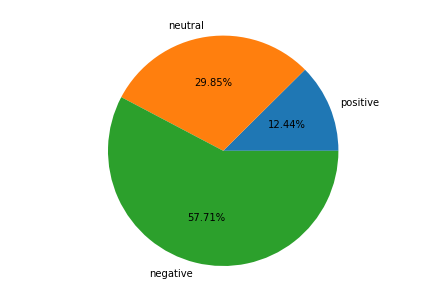

In [20]:
from matplotlib import pyplot as plt
import numpy as np
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
langs = ['positive', 'neutral', 'negative']
prediction = [pos_count,neutral_count,neg_count]
ax.pie(prediction, labels = langs,autopct='%1.2f%%')
plt.show()